In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [7]:
ifmha = pd.read_csv('./dataset/ifmha_subset_stat.csv', converters={'site_no': str}, low_memory=False)

In [4]:
us = gpd.read_file('./dataset/us_shpfile/s_08mr23.shp')

In [21]:
df = ifmha['site_no'].value_counts().to_frame()

# Add coordinates to DataFrame
df['latitude'] = ifmha.drop_duplicates(subset='site_no', keep='first').set_index('site_no')['dec_lat_va']
df['longitude'] = ifmha.drop_duplicates(subset='site_no', keep='first').set_index('site_no')['dec_long_va']

# Add channel discharge to DataFrame/ convert Imperial to SI
df['discharge'] = ifmha.groupby('site_no')['chan_discharge'].apply(lambda x: x.median())
df['discharge'] = 0.028316832 * df['discharge']

df.reset_index(inplace=True)
df.head()

,site_no,count,latitude,longitude,discharge
0,06807000,6580,40.681946,-95.846946,1050.554467
1,06486000,5477,42.485828,-96.413918,900.475258
2,06610000,5455,41.258887,-95.922514,940.118822
3,07022000,3100,37.221600,-89.462975,5493.465408
4,06601200,2992,42.007210,-96.241688,886.316842


In [22]:
df.to_csv('./dataset/choropleth_map.csv', sep=',', encoding='utf-8', index=False)

In [27]:
bins=[50, 100, 250, 500, 1000, 2500, 6580]

for idx, count in enumerate(bins):
    if idx == len(bins)-1:
        continue
    df.loc[(df['count'] >= count) & (df['count'] <= bins[idx+1]), 'count_bin' ] = idx+1

df['count_bin'] = df['count_bin'].astype(int)

In [25]:
bins=[0, 10, 50, 100, 500, 1000, 2000, 60000]

for idx, dis in enumerate(bins):
    if idx == len(bins)-1:
        continue
    df.loc[(df['discharge'] >= dis) & (df['discharge'] < bins[idx+1]), 'discharge_bin' ] = 10 * (1 + idx**2)

/var/folders/67/llrhzfgn4n3f59d6rnn20jmc0000gn/T/ipykernel_24061/1342660671.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('gist_heat').reversed()
/Users/serfani/Documents/ifmha/.venv/lib/python3.11/site-packages/matplotlib/colors.py:1318: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/serfani/Documents/ifmha/.venv/lib/python3.11/site-packages/matplotlib/colors.py:1325: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/Users/serfani/Documents/ifmha/.venv/lib/python3.11/site-packages/matplotlib/ticker.py:525: UserWarning: Warning: converting a masked element to nan.
  else fmt % arg)


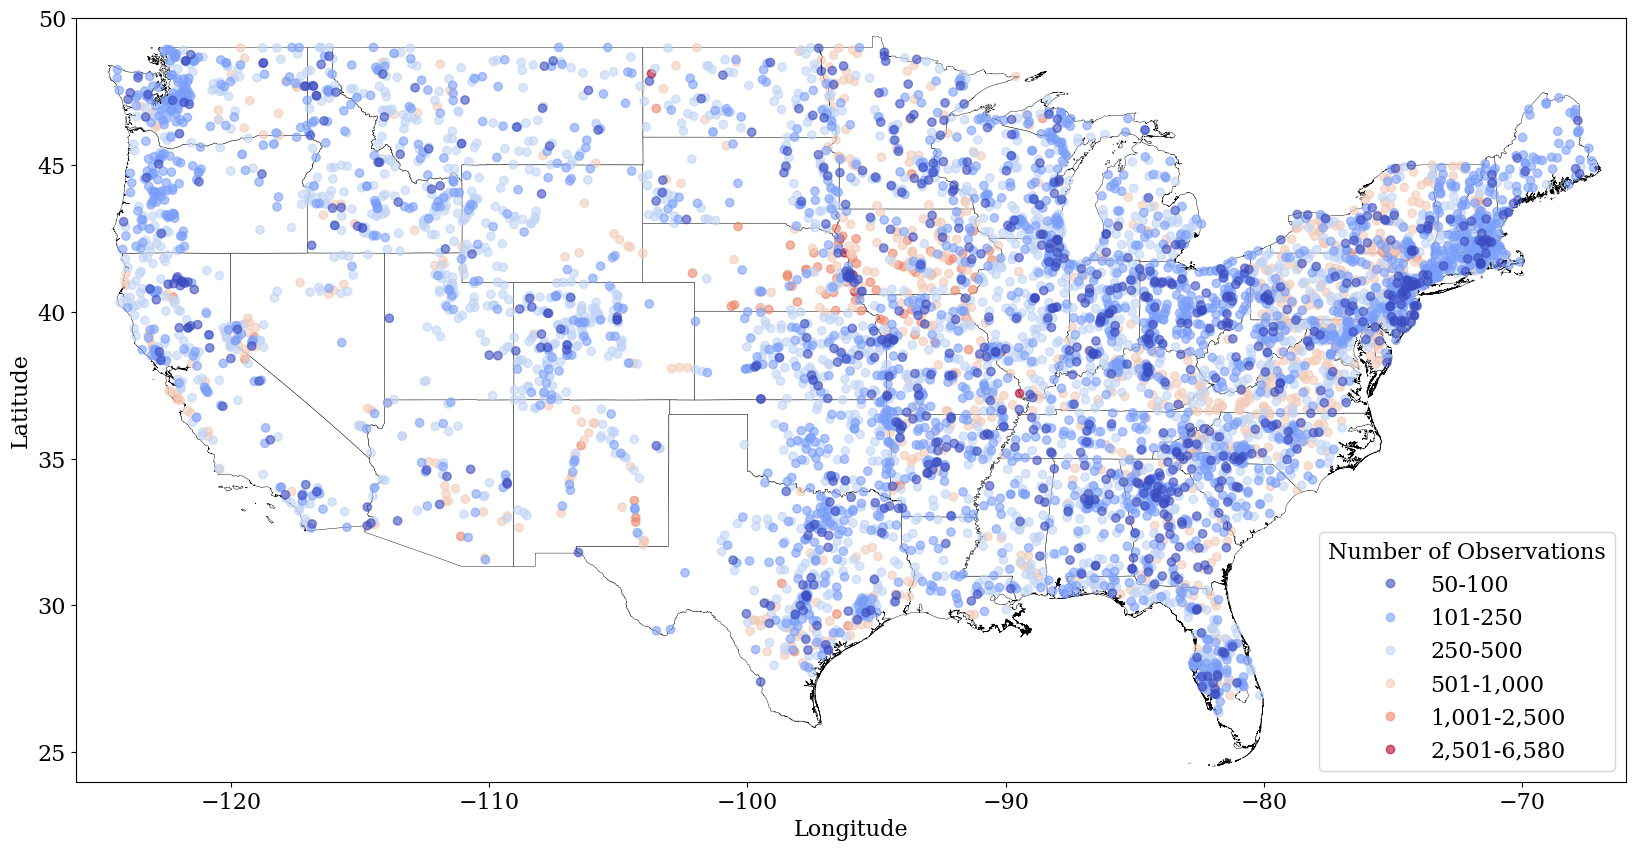

In [29]:
from matplotlib import colors
plt.rcParams.update({
    # 'font.sans-serif': 'Comic Sans MS',
    'font.family': 'serif',
    'font.size': 16
})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
us.plot(ax=ax, color='#ffffff', edgecolor='#000000', linewidth=0.3)

# cmap=plt.cm.get_cmap('gist_heat').reversed()
# sc = ax.scatter(df['longitude'], df['latitude'], s=df['discharge_scale'], c=df['site_no'], alpha=0.6, cmap='tab20c', norm=colors.LogNorm())

sc = ax.scatter(df['longitude'], df['latitude'], c=df['count_bin'],  alpha=0.6, cmap='coolwarm')
ax.set_xlim([-126, -66])
ax.set_ylim([24, 50])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')


# ax.grid(False)
# cbar = plt.colorbar(sc, pad=0.01, shrink=0.42)
# cbar.set_label('Number of Measurements', fontsize=14, labelpad=15)

handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
labels=['50-100', '101-250', '250-500', '501-1,000', '1,001-2,500', '2,501-6,580']

legend2 = ax.legend(handles, labels, loc="lower right", title=rf"Number of Observations")

f = 'pdf'
plt.savefig(f'./choropleth-scale.{f}', format=f'{f}', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [40]:
us_albers = us.to_crs(epsg=5071)

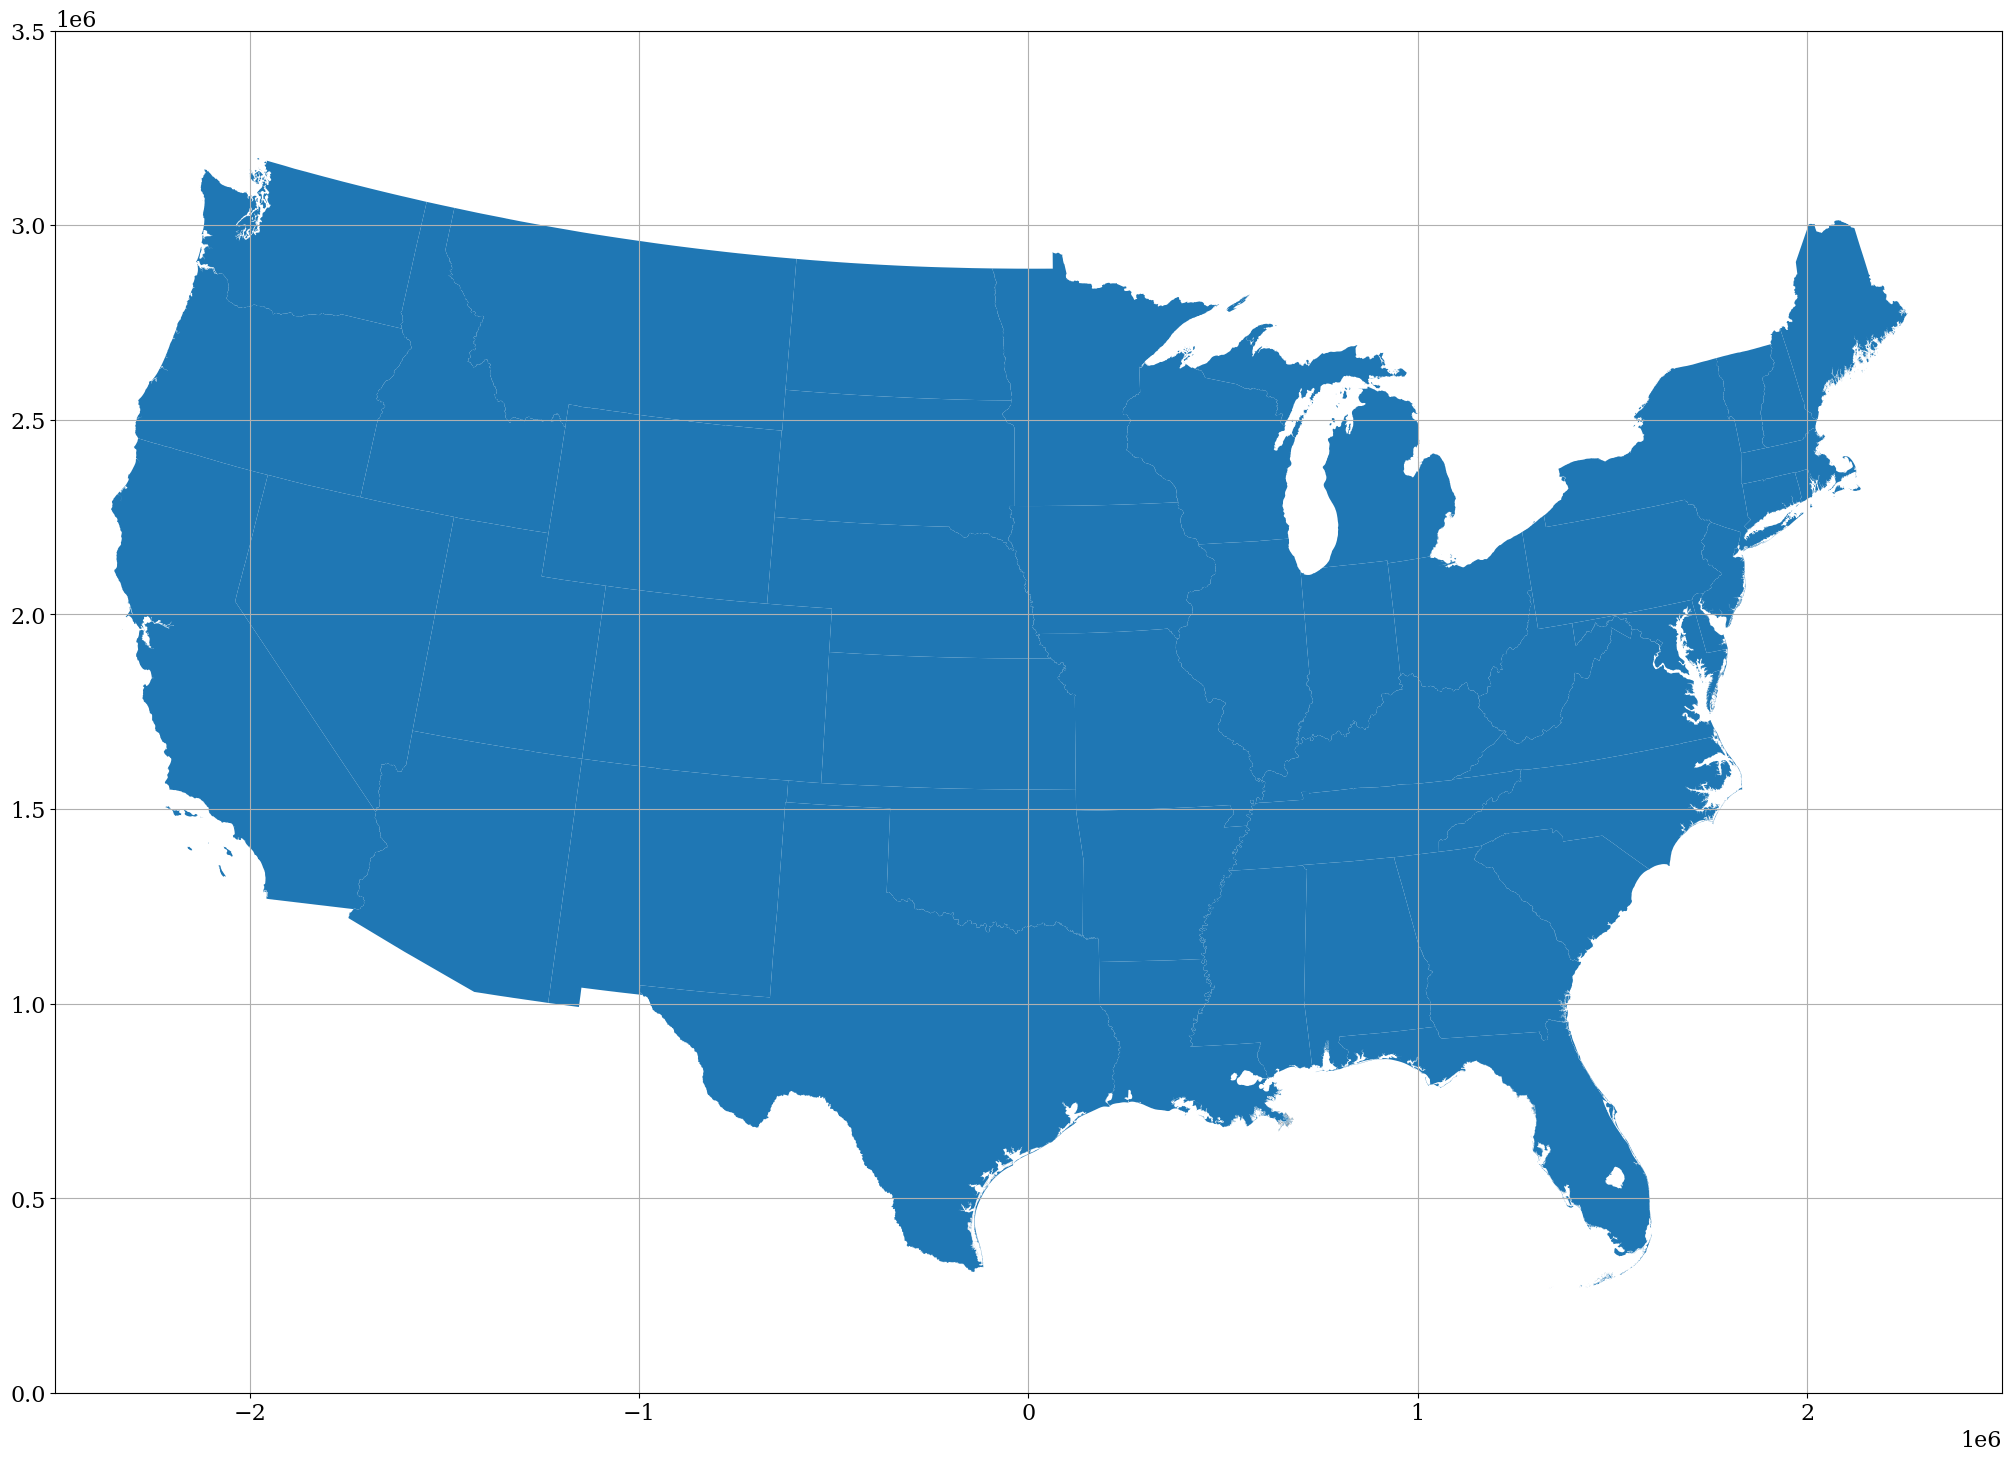

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20), constrained_layout=True)

us_albers.plot(ax=ax, legend=True)
ax.set_xlim([-2.5E6, 2.5E6])
ax.set_ylim([0E6, 3.5E6])


plt.grid(True)
plt.show()